# Ex1

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
# Função para plotar os curvas de nível constante de temperatura
def PlotaTemperature(n,m,T):
    x = np.arange(0, n, 1)
    y = np.arange(0, m, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(T)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of temperature')
    im = ax.contourf(X, Y, Z.T, 20, cmap='jet')
    im2 = ax.contour(X, Y, Z.T, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()

## Método de Jacobi

In [3]:
# Numero de pontos em cada direcao
def Jacobi(N, tol):
    Told = np.zeros(shape=(N,N))
    
    # Temperaturas nas bordas
    Told[0,  :] = 0.0 # TL
    Told[N-1,:] = 0.0 # TR
    Told[:,  0] = 0.0 # TB
    Told[:,N-1] = 20.0 # TT
    
    # Loop de iteracoes
    Nmax = 10000
    Tnew = Told.copy()
    for iter in range(Nmax):
        Tnew[1:N-1,1:N-1] = 0.25*(Told[2:N,1:N-1] + Told[0:N-2,1:N-1] + \
                                  Told[1:N-1,2:N] + Told[1:N-1,0:N-2])
        
        error = np.linalg.norm(Tnew-Told)
        #print(iter, '  ', error)
        if(error < tol):
            #print('Converged in %d iterations\n' %(iter))
            break ;
            
        Told = Tnew.copy()
        
    #PlotaTemperature(N,N,Tnew)

    return iter

## Método de Gauss-Seidel

In [4]:
# Numero de pontos em cada direcao
def Gauss_Seidel(N, tol):
    Told = np.zeros(shape=(N,N))

    # Temperaturas nas bordas
    Told[0,  :] = 0.0 # TL
    Told[N-1,:] = 0.0 # TR
    Told[:,  0] = 0.0 # TB
    Told[:,N-1] = 20.0 # TT
    
    # Loop de iteracoes
    Nmax = 10000
    Tnew = Told.copy()
    for iter in range(Nmax):
        for i in range(1,N-1):
            for j in range(1,N-1):
                Tnew[i,j] = 0.25*(Told[i+1,j] + Tnew[i-1,j] +\
                                  Told[i,j+1] + Tnew[i,j-1])
        
        error = np.linalg.norm(Tnew-Told)
        #print(iter, '  ', error)
        if(error < tol):
            #print('Converged in %d iterations\n' %(iter))
            break ;
            
        Told = Tnew.copy()
    
    #PlotaTemperature(N,N,Tnew)
    return iter

In [5]:
import tabulate as tb

tol = []
Ns = []
jacob = []
gauss = []

Jacobi(11, 1.0e-5)

for N in [11, 21, 41]:
    for tolerancia in [1.0e-5, 1.0e-8]:
        tol.append(tolerancia)
        Ns.append(N)
        jacob.append(Jacobi(N, tolerancia))
        gauss.append(Gauss_Seidel(N, tolerancia))

print(tb.tabulate(np.column_stack((Ns, tol, jacob, gauss)), headers=["N","Tolerância","Jacobi","Gauss-Seidel"], tablefmt="github", showindex="always"))

|    |   N |   Tolerância |   Jacobi |   Gauss-Seidel |
|----|-----|--------------|----------|----------------|
|  0 |  11 |        1e-05 |      243 |            131 |
|  1 |  11 |        1e-08 |      381 |            200 |
|  2 |  21 |        1e-05 |      929 |            498 |
|  3 |  21 |        1e-08 |     1487 |            776 |
|  4 |  41 |        1e-05 |     3504 |           1874 |
|  5 |  41 |        1e-08 |     5742 |           2993 |


# Ex2

In [6]:
# Função para converter indice (i,j) a indice global Ic
def ij2n (i, j, N):
    return i + j*N

# Função para montar a matriz do sistema
def MatAssembly(N):
    nunk = N**2;
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1): 
            Ic = ij2n(i,   j,   N)
            Ie = ij2n(i+1, j,   N)
            Iw = ij2n(i-1, j,   N)
            In = ij2n(i,   j+1, N)
            Is = ij2n(i,   j-1, N)
            A[Ic,[Ic,Ie,Iw,In,Is]] = [4.0, -1.0, -1.0, -1.0, -1.0]
    return A

In [7]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystem(N, TL, TR, TB, TT):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT # Ttop
    
    return Atilde, b

In [8]:
def MetodoIterativo(x, Tol, Max_it, A, b, M, acompanhar):
    k = 0
    r = np.dot(A, x) - b
    beta = 1
    while np.linalg.norm(r) > Tol and k < Max_it:
        d = np.linalg.solve(M,-r)
        x += beta*d
        r = np.dot(A, x) - b
        k += 1
        
        if acompanhar:
            print(k, " -> ", np.linalg.norm(r), "\n")

    return k, x

In [16]:
iterJacob = []
iterGauss = []
Ns = []
tol = []

for N in [11, 21, 41]:
    Atilde, b = BuildSystem(N, TL=0, TR=0, TB=0, TT=20.0)
    
    for tolerancia in [1.0e-5, 1.0e-8]:
        tol.append(tolerancia)
        Ns.append(N)

        #Jacobi
        iterJacob.append(MetodoIterativo(np.zeros(shape=len(b)), tolerancia, 1e04, Atilde, b, np.diag(np.diag(Atilde)), False)[0])
        #Gauss-Seidel
        iterGauss.append(MetodoIterativo(np.zeros(shape=len(b)), tolerancia, 1e04, Atilde, b, np.triu(Atilde), False)[0])

print(tb.tabulate(np.column_stack((Ns, tol, iterJacob, iterGauss)), headers=["N","Tolerância","Jacobi","Gauss-Seidel"], tablefmt="github", showindex="always"))

|    |   N |   Tolerância |   Jacobi |   Gauss-Seidel |
|----|-----|--------------|----------|----------------|
|  0 |  11 |        1e-05 |      272 |            135 |
|  1 |  11 |        1e-08 |      410 |            203 |
|  2 |  21 |        1e-05 |     1042 |            517 |
|  3 |  21 |        1e-08 |     1600 |            796 |
|  4 |  41 |        1e-05 |     3954 |           1968 |
|  5 |  41 |        1e-08 |     6192 |           3087 |


# Ex3

In [64]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemSim(N, TL, TR, TB, TT):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    Ic = ij2n(0,k,N) # Tleft
    for r in k:
        b[:] = b[:] - Atilde[:,Ic[r]]*TL 
        
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(N-1,k,N) # Tright
    for r in k:
        b[:] = b[:] - Atilde[:,Ic[r]]*TR
        
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,0,N) # Tbottom
    for r in k:
        b[:] = b[:] - Atilde[:,Ic[r]]*TB
        
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) # Ttop
    for r in k:
        b[:] = b[:] - Atilde[:,Ic[r]]*TT
        
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT
    Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b

Ã = 
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]] 

b = 
 [30. 30. 30. ... 40. 40. 40.]

Ã - Ã.T =  0.0

Solução =  [30. 30. 30. ... 40. 40. 40.]
Em  0.11313581466674805  segundos

Solução por método iterativo (forma de Gauss) com a matriz simétrica = 
 [30. 30. 30. ... 40. 40. 40.]
Em  130.39298844337463  segundos

Solução por método iterativo (forma de Gauss) com a matriz não-simétrica = 
 [30. 30. 30. ... 40. 40. 40.]
Em  133.73837971687317  segundos
Erro entre os dois métodos iterativos:  2.134518862384271e-09
Diferença de tempo entre os dois métodos iterativos:  -3.345391273498535


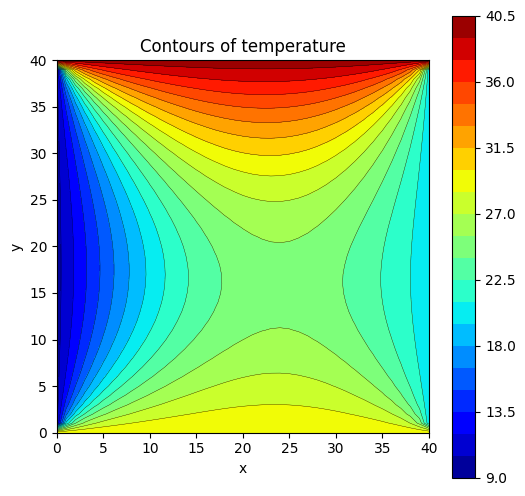

In [73]:
import time

N = 41

start_time = time.time()

Atilde, b = BuildSystemSim(N, TL=10.0, TR=20.0, TB=30.0, TT=40.0)
print("Ã = \n", Atilde, '\n\nb = \n', b)
print("\nÃ - Ã.T = ", np.linalg.norm(Atilde-Atilde.T))

import scipy
from scipy.linalg import solve

T = scipy.linalg.solve(Atilde,b)
print("\nSolução = ", T)
print("Em ", time.time() - start_time, " segundos")



start_time = time.time()

k, X = MetodoIterativo(np.zeros(shape=len(b)), 1.0e-8, 1e04, Atilde, b, np.triu(Atilde), False)
print("\nSolução por método iterativo (forma de Gauss) com a matriz simétrica = \n", x)
t1 = time.time() - start_time
print("Em ", t1, " segundos")

start_time = time.time()

Atilde, b = BuildSystem(N, TL=10.0, TR=20.0, TB=30.0, TT=40.0)

k, x = MetodoIterativo(np.zeros(shape=len(b)), 1.0e-8, 1e04, Atilde, b, np.triu(Atilde), False)
print("\nSolução por método iterativo (forma de Gauss) com a matriz não-simétrica = \n", x)
t2 = time.time() - start_time
print("Em ", t2, " segundos")



print("Erro entre os dois métodos iterativos: ", np.linalg.norm(X - x))
print("Diferença de tempo entre os dois métodos iterativos: ", t1 - t2)

Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

# Ex4

In [12]:
# Função para converter indice (i,j) a indice global Ic
def ij2n (i, j, N):
    return i + j*N

# Função para montar a matriz do sistema
def MatAssembly(N):
    nunk = N**2;
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1): 
            Ic = ij2n(i,   j,   N)
            Ie = ij2n(i+1, j,   N)
            Iw = ij2n(i-1, j,   N)
            In = ij2n(i,   j+1, N)
            Is = ij2n(i,   j-1, N)
            A[Ic,[Ic,Ie,Iw,In,Is]] = [4.0, -1.0, -1.0, -1.0, -1.0]
    return A

# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemCircular(N, Tincl, Raio, Largura):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)
    Centro = np.array((int(N/2),int(N/2)))

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0 # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0 # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0 # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0 # Ttop

    DistanciaEntreNos = Largura/N

    for i in range(N):
        for j in range(N):
            if np.linalg.norm(np.array((i-Centro[0], j-Centro[1]))) * DistanciaEntreNos <= Raio:
                Ic = ij2n(i,j,N)
                b[Ic] = Tincl
                Atilde[Ic, :] = Iden[Ic, :]
    
    return Atilde, b

In [61]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemSimCircular(N, Tincl, Raio, Largura):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)
    Centro = np.array((int(N/2),int(N/2)))

    Ic = ij2n(0,k,N) # Tleft
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(N-1,k,N) # Tright
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,0,N) # Tbottom
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) # Ttop
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], 0
    Atilde[:,Ic] = Iden[:,Ic]

    DistanciaEntreNos = Largura/N

    for i in range(N):
        for j in range(N):
            if np.linalg.norm(np.array((i-Centro[0], j-Centro[1]))) * DistanciaEntreNos <= Raio:
                Ic = ij2n(i,j,N)

                b[:] = b[:] - Atilde[:,Ic]*Tincl
        
                Atilde[Ic,:], b[Ic] = Iden[Ic,:], Tincl
                Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b

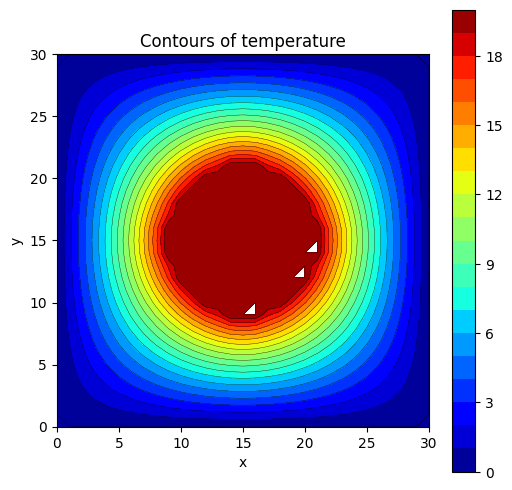

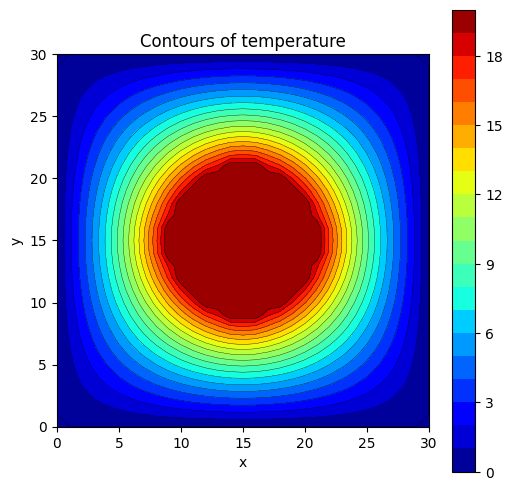

Erro entre scipy e MétodoIterativo:  1.1361464968306174e-07


In [14]:
N = 31
Atilde, b = BuildSystemCircular(N, 20, 0.2, 1)

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

k, x = MetodoIterativo(np.zeros(shape=len(b)), 1.0e-8, 1e04, Atilde, b, np.triu(Atilde), False)
Xplot = x.copy().reshape(N,N).T
PlotaTemperature(N,N,Xplot)

print("Erro entre scipy e MétodoIterativo: ", np.linalg.norm(T - x))


Ã - Ã.T =  0.0


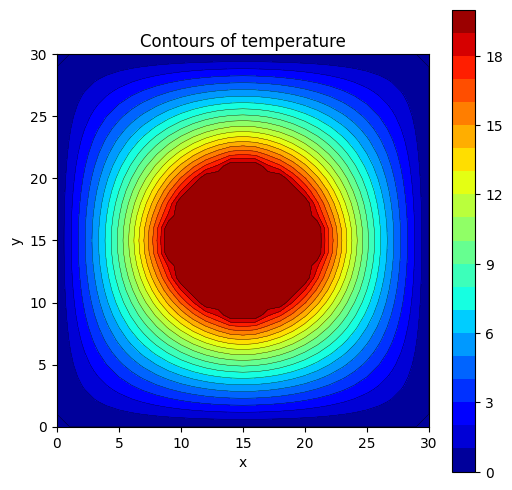

In [63]:
N = 31
Atilde, b = BuildSystemSimCircular(N, 20, 0.2, 1)

print("\nÃ - Ã.T = ", np.linalg.norm(Atilde-Atilde.T))

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)